In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xlrd
import matplotlib as mpl
import matplotlib.font_manager as fm
import datetime
from matplotlib.colors import LinearSegmentedColormap
import scipy.ndimage.filters as filters

In [7]:
df = pd.read_excel('/home/shinjk1156/Project_code/Retail_Project/Data/RFID_IPS_데이터추출_20200904.xlsx', sheet_name= None)

In [8]:
line = df['라인정보']
repeater = df["리피터 마스터"]
pog = df['POG']
pog_cate = df['POG-카테고리']
shoping = df['가공된 쇼핑 데이터']
#pog.drop(index= 0, inplace = True)
#repeater.drop(index= 0, inplace = True)
pog["POG 그룹 ID"] = pog["POG 그룹 ID"].map(str)
pog_cate["POG 그룹 ID"] = pog_cate["POG 그룹 ID"].map(str)
moving = pd.read_csv("/home/shinjk1156/Project_code/Retail_Project/Data/실시간저장데이터_20110117_20110207.txt", sep = "\t", header = None)
moving.columns = ["SINK ID", "태그 ID","TAG 강도", "리피터 ID", "저장시간"]
mer_df = pd.merge(repeater, pog, on = "POG 그룹 ID", how = "left")
mer_df

,리피터 ID,X 좌표,Y 좌표,POG 그룹 ID,스타트 여부,POS 여부,사용 강도,사용여부,상품 여부,가중치,리포트에 보여줄지에 대한 여부,POG 이름
0,REPEATER_ID,X_Coord,Y_Coord,POG_GROUP_ID,IS_START,IS_END,USE_STRENGTH,USE_YN,ITEM_SALE_YN,POINT_LEVEL,REPORT_USE_YN,POG_GROUP_DESC
1,1001,50,568,00000,Y,N,0,Y,N,3,N,NaN
2,1002,50,593,00000,Y,N,0,Y,N,3,N,NaN
3,1003,149,556,11101,N,N,0,Y,Y,3,Y,청과
4,1004,150,593,11101,N,N,0,Y,Y,3,Y,청과
...,...,...,...,...,...,...,...,...,...,...,...,...
170,1302,122,279,23001,N,N,0,Y,Y,3,N,H&B
171,1303,101,138,25301,N,N,0,Y,Y,3,N,문구
172,1304,173,279,47001,N,N,0,Y,Y,3,N,잡화
173,1305,213,209,51001,N,N,0,Y,Y,3,N,언더웨어


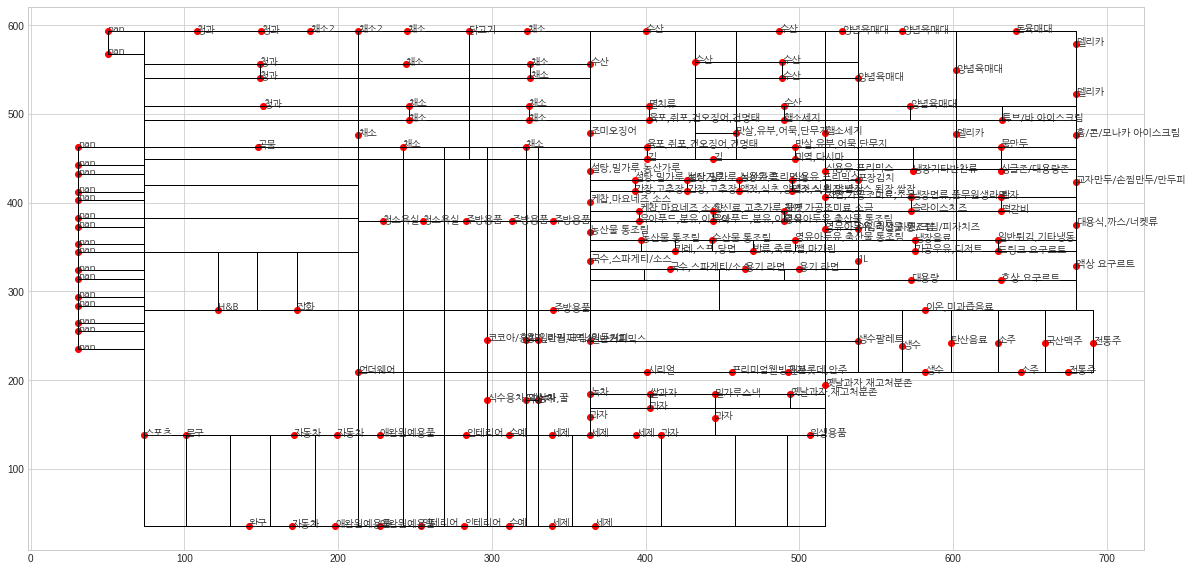

In [4]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(20,10))
plt.rcParams['lines.linewidth'] = 1
fontprop = fm.FontProperties(fname='/usr/share/fonts/truetype/Nanumfont/NanumGothic.ttf', size=10)
for i in range(1,len(line)):
    x = [line.loc[i,"시작 X 좌표"], line.loc[i,"종료 X 좌표"]]
    y = [line.loc[i,"시작 Y 좌표"], line.loc[i,"종료 Y 좌표"]]
    plt.plot(x,y, color= "black")

for i in range(1, len(repeater)):
    plt.scatter(repeater.loc[i,"X 좌표"], repeater.loc[i, "Y 좌표"], color = "red")
    plt.text(repeater.loc[i,"X 좌표"], repeater.loc[i, "Y 좌표"], mer_df.loc[i, "POG 이름"], fontsize = 10, fontproperties = fontprop)
#fig.savefig("Black_line_with_text.png")

In [15]:
#moving = pd.read_csv("/home/shinjk1156/Project_code/Retail_Project/Data/실시간저장데이터_20110117_20110207.txt", sep = "\t", header = None)
moving = pd.read_csv("/home/shinjk1156/Project_code/Retail_Project/Data/실시간저장데이터_20110208_20110220.txt", sep = "\t", header = None)

In [18]:
repeater

,리피터 ID,X 좌표,Y 좌표,POG 그룹 ID,스타트 여부,POS 여부,사용 강도,사용여부,상품 여부,가중치,리포트에 보여줄지에 대한 여부
0,REPEATER_ID,X_Coord,Y_Coord,POG_GROUP_ID,IS_START,IS_END,USE_STRENGTH,USE_YN,ITEM_SALE_YN,POINT_LEVEL,REPORT_USE_YN
1,1001,50,568,00000,Y,N,0,Y,N,3,N
2,1002,50,593,00000,Y,N,0,Y,N,3,N
3,1003,149,556,11101,N,N,0,Y,Y,3,Y
4,1004,150,593,11101,N,N,0,Y,Y,3,Y
...,...,...,...,...,...,...,...,...,...,...,...
170,1302,122,279,23001,N,N,0,Y,Y,3,N
171,1303,101,138,25301,N,N,0,Y,Y,3,N
172,1304,173,279,47001,N,N,0,Y,Y,3,N
173,1305,213,209,51001,N,N,0,Y,Y,3,N


In [5]:
sample = moving[(moving.저장시간 > shoping.loc[1,"쇼핑 시작시간"]) & (moving.저장시간 < shoping.loc[1,"쇼핑 종료 시간"]) & (moving["태그 ID"] ==shoping.loc[1, "태그 ID"])]
sample.sort_values(by = "저장시간", inplace = True)
sample = pd.merge(sample, repeater, on = "리피터 ID", how = "left")

In [6]:
to_shop = pd.DataFrame()
for i in tqdm(range(1, len(shoping),1)):
    sample = moving[(moving.저장시간 > shoping.loc[i,"쇼핑 시작시간"]) & (moving.저장시간 < shoping.loc[i,"쇼핑 종료 시간"]) & (moving["태그 ID"] ==shoping.loc[i, "태그 ID"])]
    if len(sample) == 0:
        pass
    else:
        sample.sort_values(by = "저장시간", inplace = True)
        sample = pd.merge(sample, repeater, on = "리피터 ID", how = "left")
        t_list = [shoping.loc[i,"쇼핑 ID"]]*len(sample)
        sample["쇼핑 ID"] = t_list
        to_shop = to_shop.append(sample)

100%|██████████| 13865/13865 [5:09:23<00:00,  1.34s/it]


In [7]:
to_shop.to_csv("동선_전처리.csv", index = False)

In [13]:
new_df = pd.read_csv("동선_전처리.csv")

In [14]:
new_df.sort_values("저장시간")

,SINK ID,태그 ID,TAG 강도,리피터 ID,저장시간,X 좌표,Y 좌표,POG 그룹 ID,스타트 여부,POS 여부,사용 강도,사용여부,상품 여부,가중치,리포트에 보여줄지에 대한 여부,쇼핑 ID
37357,148,50,1,1010,2011-01-22 13:31:58.577,242.0,463.0,11201.0,N,N,0.0,Y,Y,3.0,Y,309.0
72125,142,80,1,1058,2011-01-22 13:31:58.687,575.0,358.0,16701.0,N,N,0.0,Y,Y,3.0,Y,539.0
37358,148,50,0,1010,2011-01-22 13:31:59.127,242.0,463.0,11201.0,N,N,0.0,Y,Y,3.0,Y,309.0
96170,138,98,1,1118,2011-01-22 13:31:59.453,517.0,194.0,20101.0,N,N,0.0,Y,Y,3.0,Y,686.0
72126,142,80,1,1058,2011-01-22 13:31:59.530,575.0,358.0,16701.0,N,N,0.0,Y,Y,3.0,Y,539.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139504,150,94,1,1047,2011-02-07 17:09:39.547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14858.0
2152076,142,135,1,1054,2011-02-07 17:09:39.657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14970.0
2150526,144,117,1,1083,2011-02-07 17:09:39.657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14938.0
2166223,143,175,1,1097,2011-02-07 17:09:39.703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15112.0


In [9]:
print("# of ERRORs : {0}".format(len(shoping) - len(new_df["쇼핑 ID"].unique())))

# of ERRORs : 7237


In [9]:
shoping.loc[1,:]

쇼핑 ID                             1
쇼핑 일자                      20110122
태그 ID                           001
쇼핑 시간                           869
쇼핑 시작시간     2011-01-22 15:04:43.467
쇼핑 종료 시간    2011-01-22 15:19:12.267
결제 시작 시간    2011-01-22 15:19:12.267
결제 종료 시간    2011-01-22 15:19:12.267
결제 금액                        104228
결제 회원                00000009332886
Name: 1, dtype: object

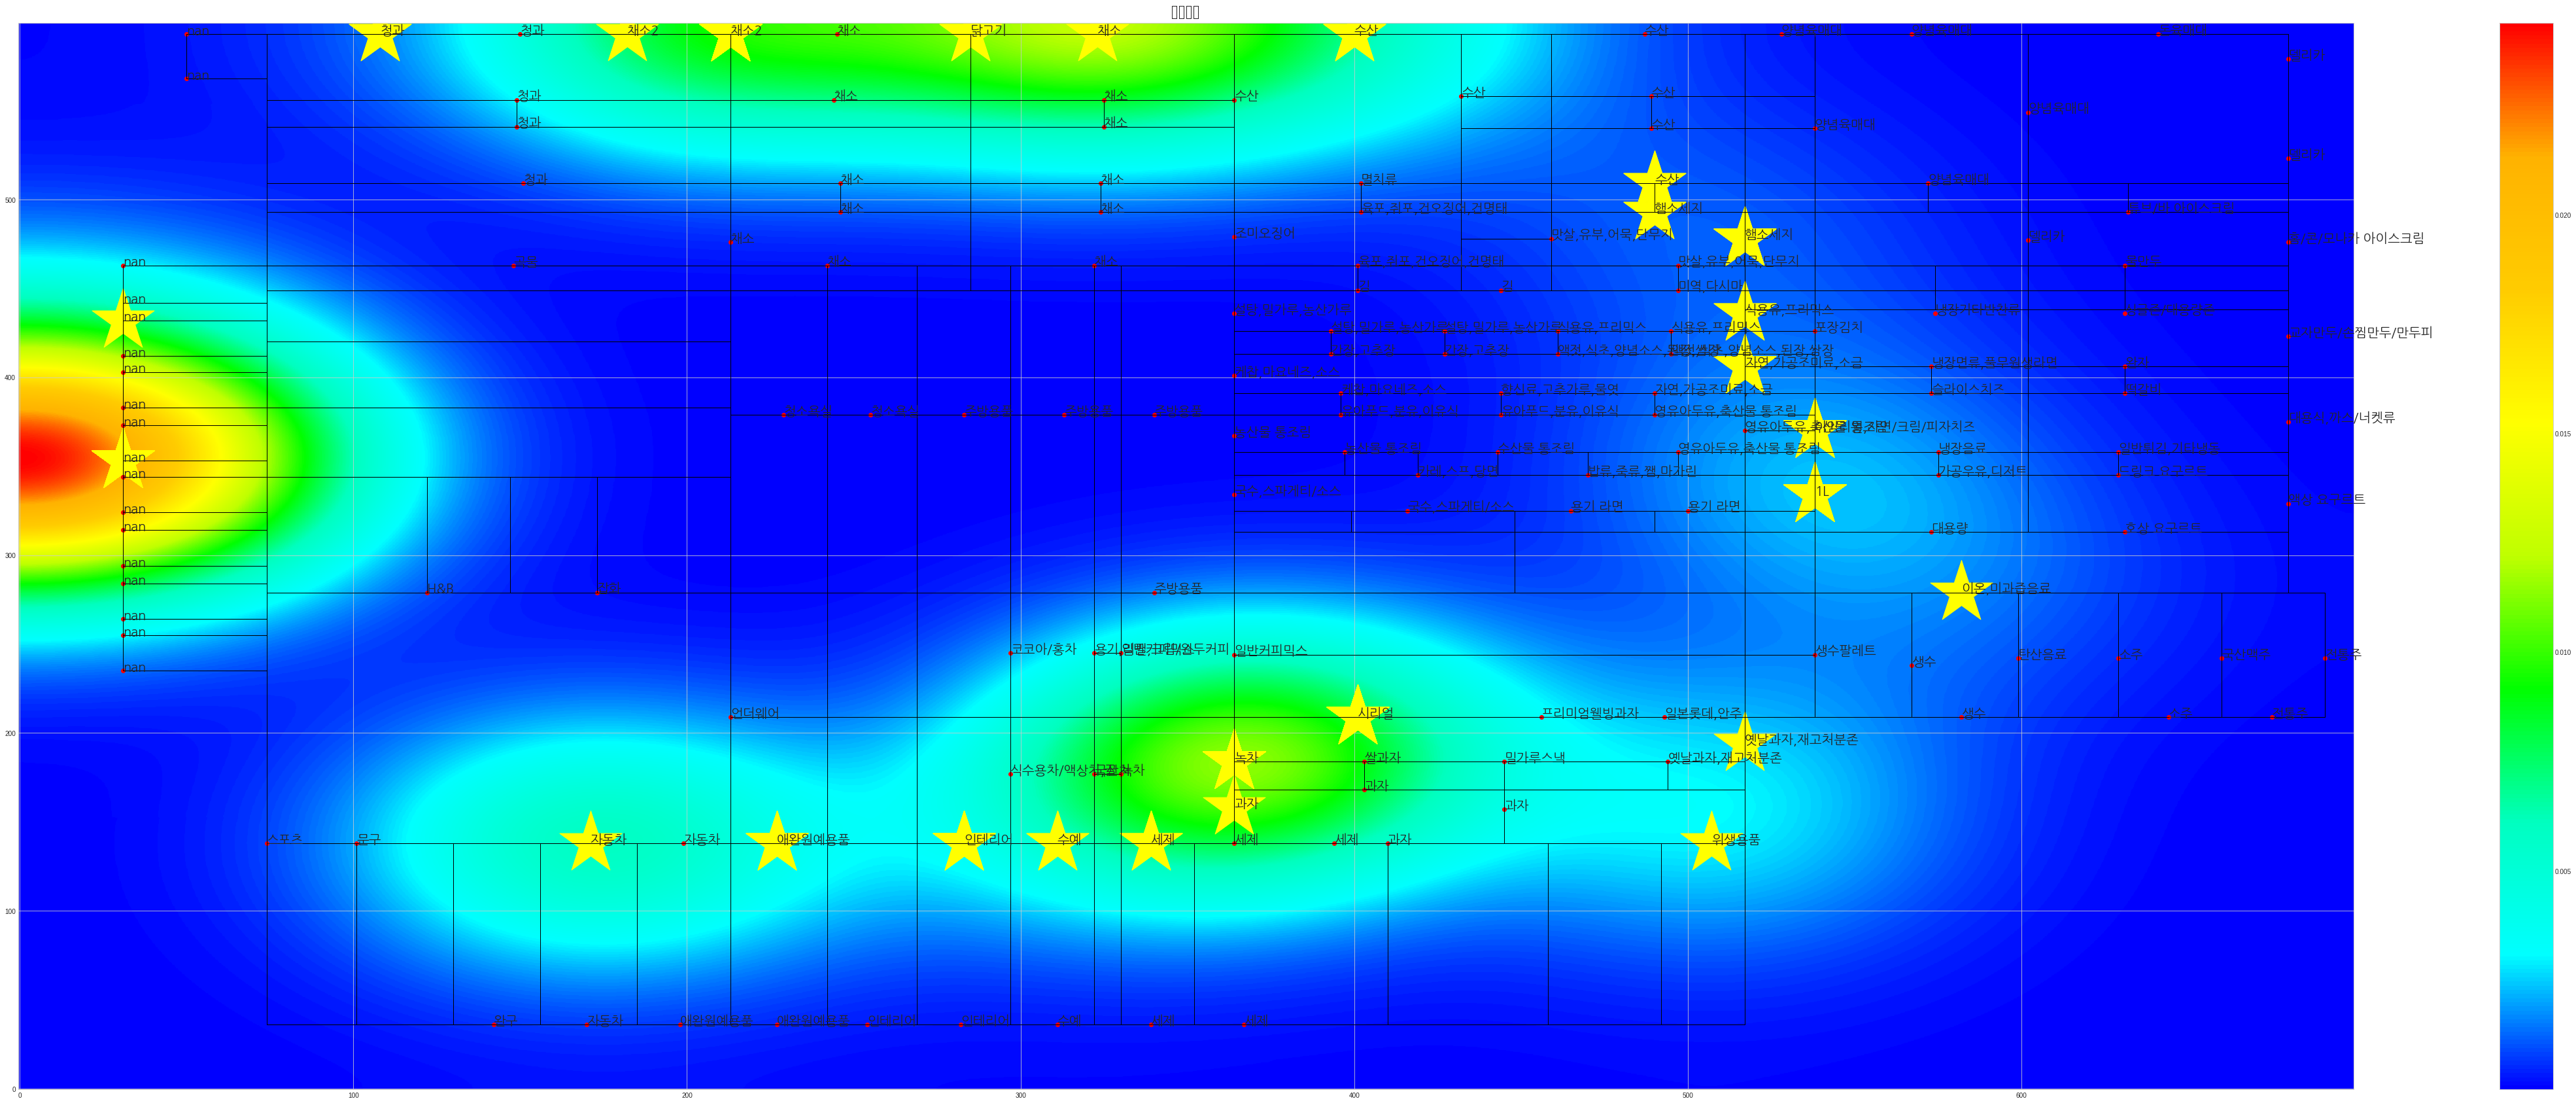

In [8]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
fig.set_size_inches(80,30)
plt.rcParams['lines.linewidth'] = 1
for i in range(1,len(line)):
    x = [line.loc[i,"시작 X 좌표"], line.loc[i,"종료 X 좌표"]]
    y = [line.loc[i,"시작 Y 좌표"], line.loc[i,"종료 Y 좌표"]]
    
    plt.plot(x,y, color= "black")
    

for i in range(1, len(mer_df)):
    plt.scatter(mer_df.loc[i,"X 좌표"], mer_df.loc[i, "Y 좌표"], color = "red")
    plt.text(mer_df.loc[i,"X 좌표"], mer_df.loc[i, "Y 좌표"], mer_df.loc[i, "POG 이름"], fontsize = 20 , fontproperties = fontprop)
#fig.savefig("Black_line_with_text.png")

w = 700
h = 600

data = np.zeros(w * h)
data = data.reshape((h, w))
for i in range(0, len(sample)-1):
    plt.scatter(sample.loc[i,"X 좌표"], sample.loc[i, "Y 좌표"], color = "yellow", s= 10000, marker = "*" )
    #plt.text(sample.loc[i,"X 좌표"], sample.loc[i, "Y 좌표"], i, fontsize = 20)
    
    start = datetime.datetime.strptime(str(sample.loc[i, "저장시간"]), "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.datetime.strptime(str(sample.loc[i+1, "저장시간"]), "%Y-%m-%d %H:%M:%S.%f")
    time = end - start
    data[sample.loc[i, "Y 좌표"], sample.loc[i, "X 좌표"]] += time.total_seconds()



# Smooth it to create a "blobby" look
data = filters.gaussian_filter(data, sigma=50)
colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0.75), (0, 1, 0), (0.75, 1, 0),
            (1, 1, 0), (1, 0.8, 0), (1, 0.7, 0), (1, 0, 0)]

cm = LinearSegmentedColormap.from_list('sample', colors)
plt.imshow(data, cmap=cm , origin = 'lower', aspect = 'auto')
plt.colorbar()
plt.title("체류시간", fontdict = {'fontsize' : 30})
plt.savefig("stay_time.png")
#plt.close()
plt.show()
